In [2]:
# TODO, maybe draw and analyse anchor positive assignemtn among different pyrimid level
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D, set_bev_background
from util_kitti import AVG_HEIGT, AVG_WIDTH, AVG_LENTH, init_zy_plt, init_xz_plt, load_tf_image_fpn, init_img_plt_without_bev
from util_kitti import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, init_img_plt, load_tf_image, type_dict, shape_dict
from util_kitti import draw_corner_2D, draw_birdeyes, calc_iou, draw_2Dbox, KITTI_Object, gac_original_anchor_parser
from anchor_assignment_method import maxIoU

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2

import glob
from collections import defaultdict

LABEL_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
CALIB_DIR = "/home/lab530/KenYu/kitti/training/calib/"
TRAIN_SPLIT = " /home/lab530/KenYu/visualDet3D/visualDet3D/data/kitti/chen_split/train.txt"


# 'anchor_gac': GAC original anchors
# 'anchors_adaptive'
# 'anchors_adaptive_Yoffset'
# 'anchors_bev_dense'
# 'anchors_fpn'
# 'anchors_gac_fpn_share_weight'
# 'BEV_anchor'
# 'anchor_single_pixel'
# 'anchor_center3D' : Cover rate = 90.53590719083181%
ANCHOR_GENERATION_METHOD = 'anchor_gac' # 'anchor_center3D'
ANCHOR_ASSIGNMENT_METHOD = "maxIoU" # "maxIoU", "L1distance", "3Ddistance"
SHOW_IMAGE = ['000169', '000173', '000185', '000296', '000008']# ['000169', '000173', '000185', '000296', '000008'] # 000169 '000369' 


if ANCHOR_GENERATION_METHOD == "anchor_gac": # max_occlusion_999_anchor , max_occlusion_2_anchor
    
    # This P2 is a bit dummy
    P2 = kitti_calib_file_parser(CALIB_DIR + "000169.txt", new_shape_tf = (288, 1280), crop_tf=100)
    # Load GAC's anchor
    anchor_2D, anchor_3D, anchor_mask, anchors = gac_original_anchor_parser("/home/lab530/KenYu/visualDet3D/anchor/max_occlusion_999_anchor.pkl", P2)
    # anchor_2D, anchor_3D, anchor_mask, anchors = gac_original_anchor_parser("/home/lab530/KenYu/visualDet3D/anchor/max_occlusion_999_stride_8_anchor.pkl", P2)
       
    # Convert to anchors_tensor
    anchors_tensor = []
    for a in anchors:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0, a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha, a.x3d, a.y3d, a.z3d, a.rot_y])
    anchors_tensor = torch.FloatTensor(anchors_tensor)
else:
    # Load dense anchor
    with open(f"/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/{ANCHOR_GENERATION_METHOD}.pkl", "rb") as f:
        anchors_tensor = pickle.load(f)
    # print(f"anchors_tensor = {anchors_tensor.shape}") # torch.Size([28800, 16])

    P2 = kitti_calib_file_parser(CALIB_DIR + "000169.txt", new_shape_tf = (288, 1280), crop_tf=100)
    
    # Get anchors objects
    anchors = []
    for a in anchors_tensor:
        # anchors_tensor = [x1, y1, x2, y2, 0, cx, cy, cz, w, h, l, alpha, x3d, y3d, z3d, rot_y]
        #                   0   1   2   3   4  5   6   7   8  9  10 11     12   13   14   15
        #'category, truncated, occluded, alpha, xmin, ymin, xmax, ymax, height, width, length, x3d, y3d, z3d, rot_y, score]
        # 0         1          2         3      4     5     6     7     8       9      10      11   12   13   14     15
        str_line = f"Car NA NA {a[11]} {a[0]} {a[1]} {a[2]} {a[3]} {a[9]} {a[8]} {a[10]} {a[12]} {a[13]} {a[14]} {a[15]} NA"
        anchors.append( KITTI_Object(str_line, tf_matrix = P2) )

# Load ALL labels
labels_all = []
label_dict = defaultdict(list) # {'000169': [1,3,6,8], ...}
c = 0
for fn in glob.glob(LABEL_DIR + "*.txt"):
    name = fn.split('/')[-1].split('.')[0]
    
    img_ori_h, img_ori_w, _ = shape_dict[ type_dict[name] ]
    
    # For GAC
    P2_label = kitti_calib_file_parser(CALIB_DIR + fn.split('/')[-1], 
                                       new_shape_tf = (288, 1280), 
                                       crop_tf = 100)
    
    for label in kitti_label_file_parser(fn, tf_matrix = P2_label):
        # filter labal via gac_original's critiria
        # if label.occluded >= 2 or label.z3d <= 3 or label.category != "Car":
        #     continue
        if label.category != "Car":
            continue
        else:
            # Transform 2D label because of crop and resize operation
            label.transform_2d_bbox_manually(img_ori_h, crop_tf = 100, resize_tf = (288, 1280))
            label_dict[label.idx_img].append(c)
            labels_all.append(label)
            c += 1

print(f"Number of total ground trues = {len(labels_all)}")
# print(f"Number of total label file = {len(label_dict)}") # 
print("=====================================")

# Load images
imgs_tf = []
for img_id in SHOW_IMAGE:
    img = load_tf_image(f"/home/lab530/KenYu/kitti/training/image_2/{img_id}.png")
    imgs_tf.append(img)

# # This for fpn
# imgs_tf = []
# for img_id in SHOW_IMAGE:
#     img = load_tf_image_fpn(f"/home/lab530/KenYu/kitti/training/image_2/{img_id}.png")
#     imgs_tf.append(img)
# print(anchors)


Useful anchor = 19300 / 46080 
Number of total ground trues = 28742


# Draw Anchor Assignment result 

Total number of Assignment = 1645550
Total GroundTrue = 28742
Total covered groundtrue = 27128
Total missed groundtrue = 1614
Average anchors for every groundtrue = 57.252452856447015
Average cx distance = 71.11989702100337
Average cy distance = 30.2016823630779
Average x3d distance = 1.0144224491168148
Average y3d distance = 0.27047460939960516
Average z3d distance = 2.4687702989336744
Cover rate = 94.38452438939531%
Number of Effective Anchor = 14789
Number of Total Anchor = 19300
Anchor Effectiveness Rate = 76.62694300518135%


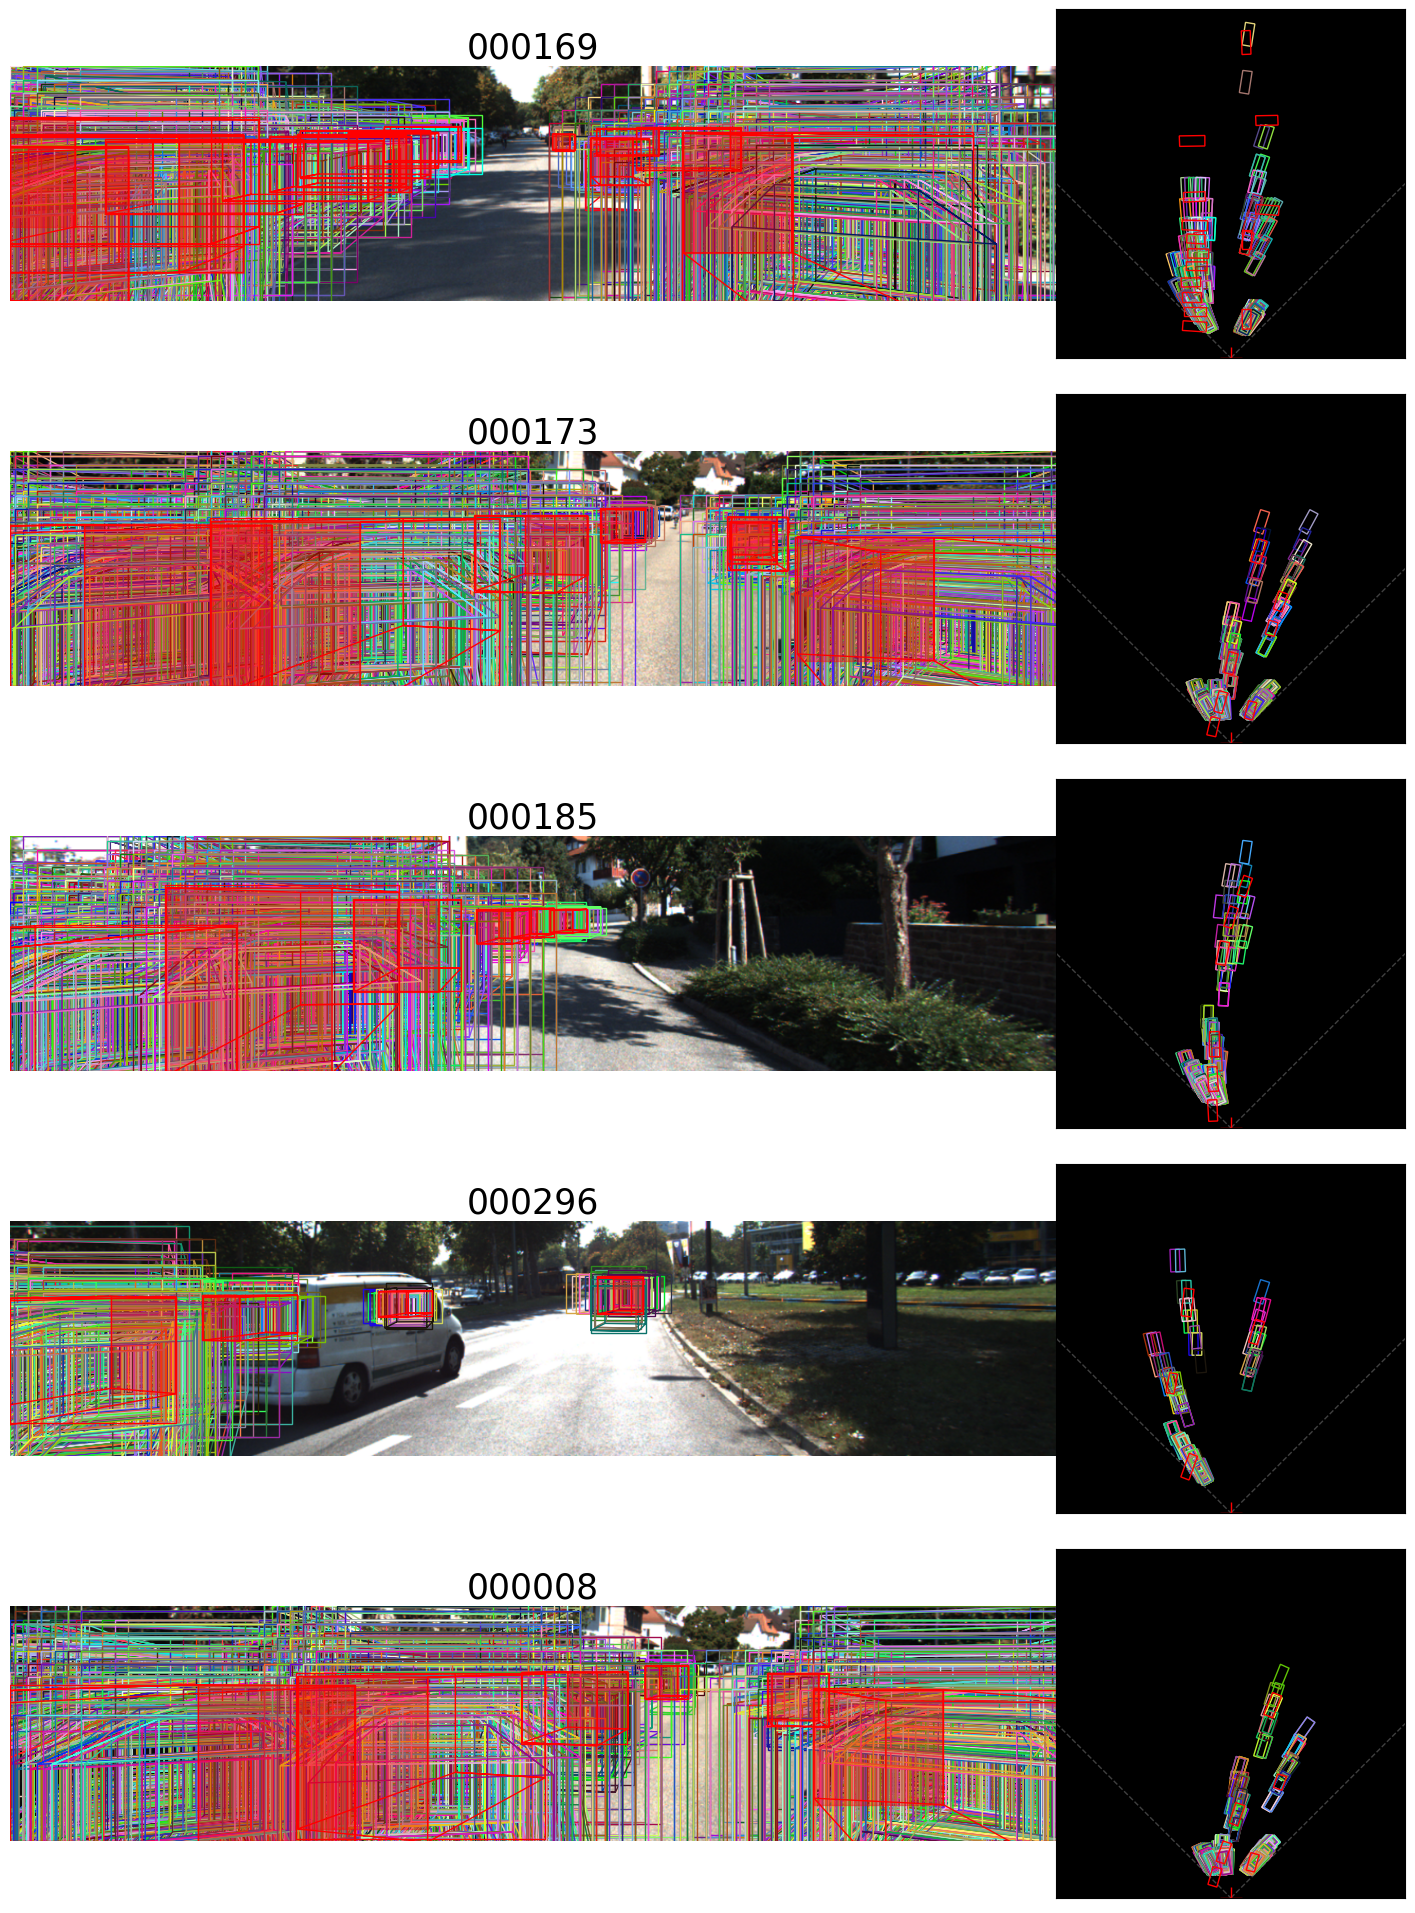

In [3]:
axs = init_img_plt(imgs_tf, SHOW_IMAGE)

gt_assign_result = [[] for _ in range(len(labels_all))]
for idx_img in label_dict:
    # # TODO 
    # if idx_img != '000169': continue

    labels = [ labels_all[i] for i in label_dict[idx_img] ]
    if ANCHOR_ASSIGNMENT_METHOD == 'maxIoU':
        # Get labels_tensor for maxIoU
        labels_tensor = []
        for label in labels:
            labels_tensor.append([label.xmin, label.ymin, label.xmax, label.ymax])
        labels_tensor = torch.FloatTensor(labels_tensor)
        
        # Calculate maxIoU
        pos_inds, neg_inds, anchor_assignment = maxIoU(anchors_tensor, labels_tensor)

    elif ANCHOR_ASSIGNMENT_METHOD == '3Ddistance':
        ##################################################
        ### Anchor assignment via Norm_1 of (x3d, z3d) ###
        ##################################################
        # TODO maybe align with bev_ank_head.py
        # this won't work for now 
        raise NotImplementedError
        for idx_lable, label in enumerate(labels):
            norm_1 = abs(anchors_tensor[:, 12] - label.x3d) + abs(anchors_tensor[:, 14] - label.z3d)
            norm_1[ torch.abs(torch.cos(anchors_tensor[:, 15] - label.rot_y)) < pi/4 ] = float('inf')
            values, indexes = torch.topk(norm_1, 4, largest=False)
            pos_inds = indexes

    elif ANCHOR_ASSIGNMENT_METHOD == 'L1distance':
        ##################################################
        ### Anchor assignment via distance of (cx cy) ####
        ##################################################
        # TODO maybe align with bev_ank_head.py
        # this won't work for now 
        raise NotImplementedError
        for idx_lable, label in enumerate(labels):
            dist = abs(anchors_tensor[:, 5] - label.cx) + abs(anchors_tensor[:, 6] - label.cy)
            dist[ torch.abs(torch.cos(anchors_tensor[:, 15] - label.rot_y)) < pi/4 ] = float('inf')
            dist[ torch.abs(anchors_tensor[:, 7] - label.cz) > 2 ] = float('inf')
            pos_inds = torch.nonzero(dist < 16*1.414, as_tuple=False).squeeze()

    n_pos = pos_inds.shape[0]
    # n_neg = neg_inds.shape[0]
    # if idx_img == '000008':
    #     print(f"n_pos = {n_pos}")
    #     print(f"pos_inds = {pos_inds}")

    n_gt = len(labels)
    # 
    unique, counts = torch.unique(anchor_assignment, return_counts=True)
    anchor_assign = dict(zip(unique.cpu().numpy(), counts.cpu().numpy())) # {0.0: 9308, 1.0: 24}
    
    for i in range(n_gt):
        if i in anchor_assign:
            assign_list = (anchor_assignment == i).nonzero(as_tuple=True)[0].numpy().tolist()
            gt_assign_result[ label_dict[idx_img][i] ] = assign_list
            # print(f"assign_list in assignemnt = {assign_list}")

    if idx_img in SHOW_IMAGE:
        idx_show = SHOW_IMAGE.index(idx_img)
        
        # Draw Positive anchors
        for i in range(n_pos):
            color = (random.random(), random.random(), random.random())
            draw_corner_2D(axs[idx_show][0], anchors[pos_inds[i]].corner_2D, color = color, is_draw_front = False)
            draw_2Dbox(axs[idx_show][0], (anchors[pos_inds[i]].xmin, anchors[pos_inds[i]].ymin, anchors[pos_inds[i]].xmax, anchors[pos_inds[i]].ymax), color = color)
            draw_birdeyes(axs[idx_show][1], anchors[pos_inds[i]], color = color)

        # Draw ground true 3d bbox
        for label in labels:
            draw_corner_2D(axs[idx_show][0], label.corner_2D,  color = (1,0,0))
            draw_2Dbox(axs[idx_show][0], (label.xmin, label.ymin, label.xmax, label.ymax), color = (1,0,0))
            draw_birdeyes(axs[idx_show][1], label, color = (1,0,0))

# Get number of covered groundTrue
n_cover_gt = 0
for assign_list in gt_assign_result:
    if len(assign_list) > 0:
        n_cover_gt += 1

# Get number of assignment
n_assign = 0
for assign_list in gt_assign_result:
    n_assign += len(assign_list)

# Invert dict
ak_assign_result = [[] for _ in range(anchors_tensor.shape[0])]
for i_gt, assign_list in enumerate(gt_assign_result):
    for a in assign_list:
        ak_assign_result[a].append(i_gt)

# Get number of effective anchor
num_effective_anchor = 0
for l in ak_assign_result:
    if len(l) != 0:
        num_effective_anchor += 1
        
# Get average L1 distance
avg_cx_dist = 0
avg_cy_dist = 0
avg_x3d_dist = 0
avg_y3d_dist = 0
avg_z3d_dist = 0
for idx_label, assign_list in enumerate(gt_assign_result):
    for idx_anchor in assign_list:
        avg_cx_dist += abs(anchors[idx_anchor].cx - labels_all[idx_label].cx) / n_assign
        avg_cy_dist += abs(anchors[idx_anchor].cy - labels_all[idx_label].cy) / n_assign
        avg_x3d_dist += abs(anchors[idx_anchor].x3d - labels_all[idx_label].x3d) / n_assign
        avg_y3d_dist += abs(anchors[idx_anchor].y3d - labels_all[idx_label].y3d) / n_assign
        avg_z3d_dist += abs(anchors[idx_anchor].z3d - labels_all[idx_label].z3d) / n_assign

print(f"Total number of Assignment = {n_assign}")
print(f"Total GroundTrue = {len(labels_all)}")
print(f"Total covered groundtrue = {n_cover_gt}")
print(f"Total missed groundtrue = {len(labels_all) - n_cover_gt}")
print(f"Average anchors for every groundtrue = {n_assign / len(labels_all)}")
print(f"Average cx distance = {avg_cx_dist}")
print(f"Average cy distance = {avg_cy_dist}")
print(f"Average x3d distance = {avg_x3d_dist}")
print(f"Average y3d distance = {avg_y3d_dist}")
print(f"Average z3d distance = {avg_z3d_dist}")
print(f"Cover rate = {100*n_cover_gt / len(labels_all)}%")
print(f"Number of Effective Anchor = {num_effective_anchor}")
print(f"Number of Total Anchor = {len(ak_assign_result)}")
print(f"Anchor Effectiveness Rate = {100*num_effective_anchor / len(ak_assign_result)}%")



# Analyse anchor assignment on ZY plane

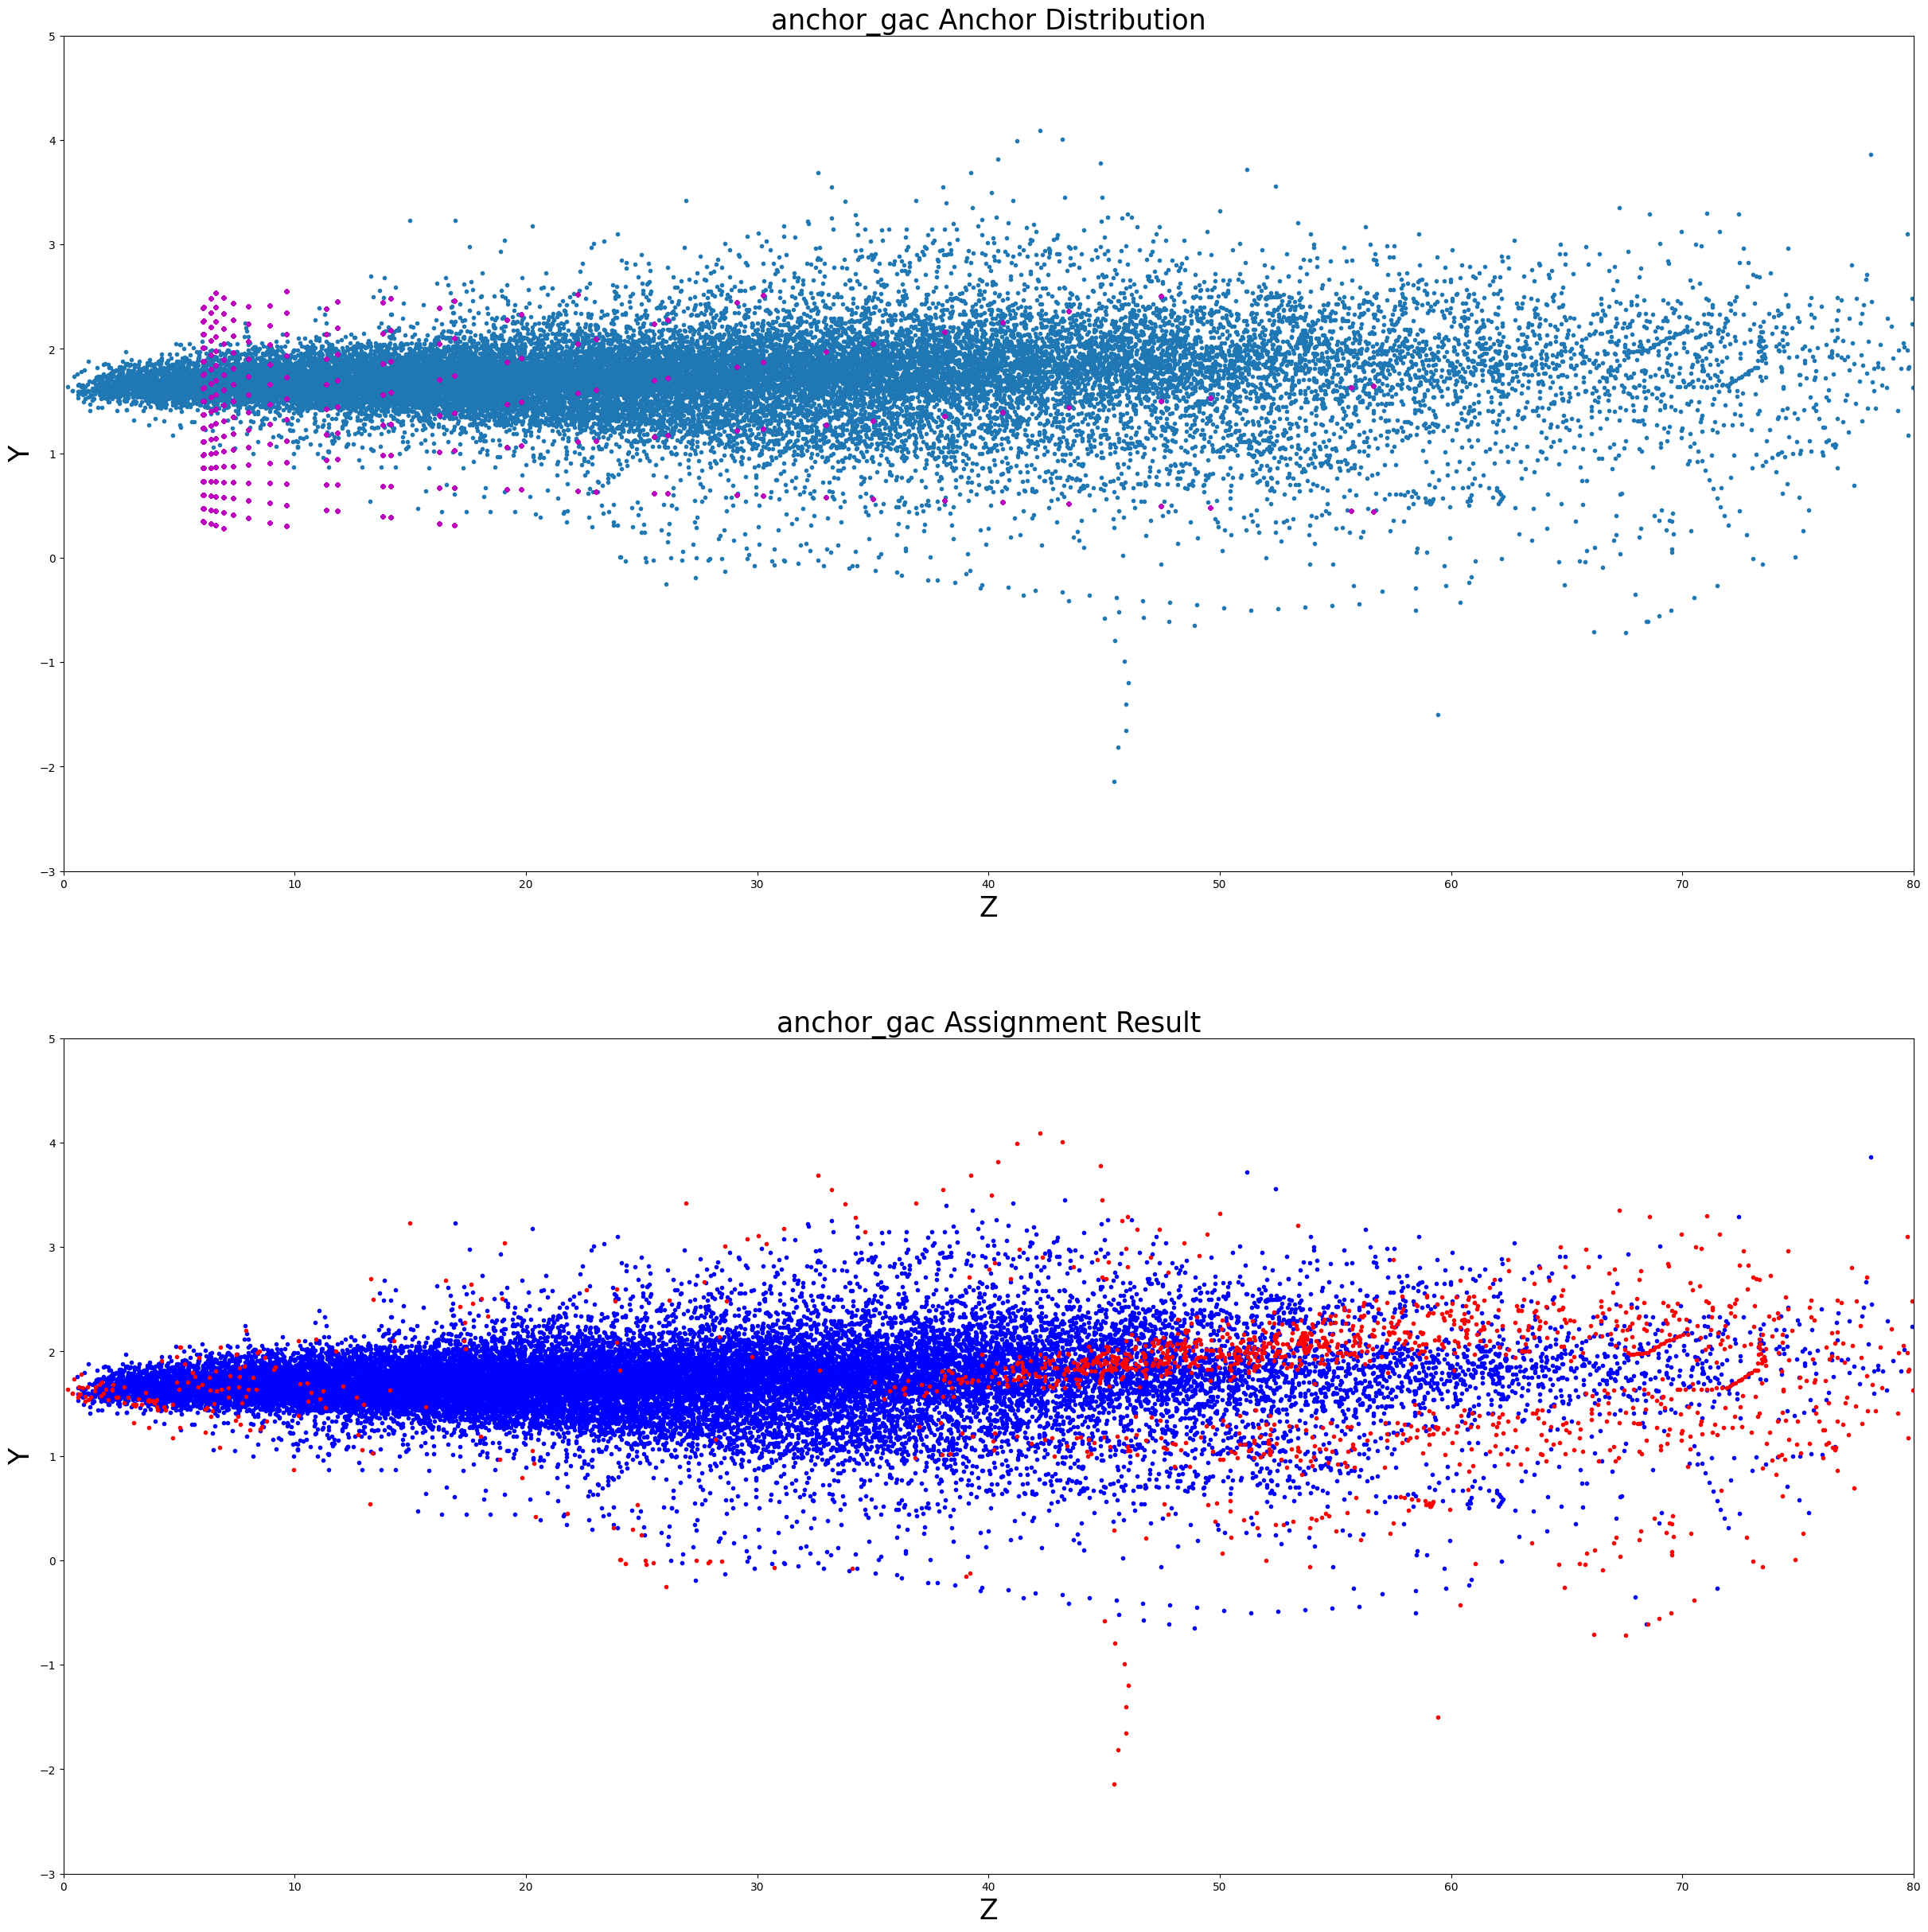

In [4]:
axs = init_zy_plt([f"{ANCHOR_GENERATION_METHOD} Anchor Distribution", f"{ANCHOR_GENERATION_METHOD} Assignment Result"])

# Draw Ground true
axs[0].plot([l.z3d for l in labels_all], [l.y3d for l in labels_all], '.') # Draw ground true

# Draw anchors, TODO, disable only becuase it's 2D detector
axs[0].plot([a.z3d for a in anchors], [a.y3d for a in anchors], '.m',) # Draw filtered GAC anchor

covered_gt_list = []
missed_gt_list = []
for i, assign_list in enumerate(gt_assign_result):
    if len(assign_list) > 0: # Covered gt
        covered_gt_list.append(i)
    else:
        missed_gt_list.append(i)

# Draw Assignemnt result
axs[1].plot([labels_all[i].z3d for i in covered_gt_list], [labels_all[i].y3d for i in covered_gt_list], '.b',)
axs[1].plot([labels_all[i].z3d for i in missed_gt_list], [labels_all[i].y3d for i in missed_gt_list], '.r',)



# Anchor Assignment on XZ plane

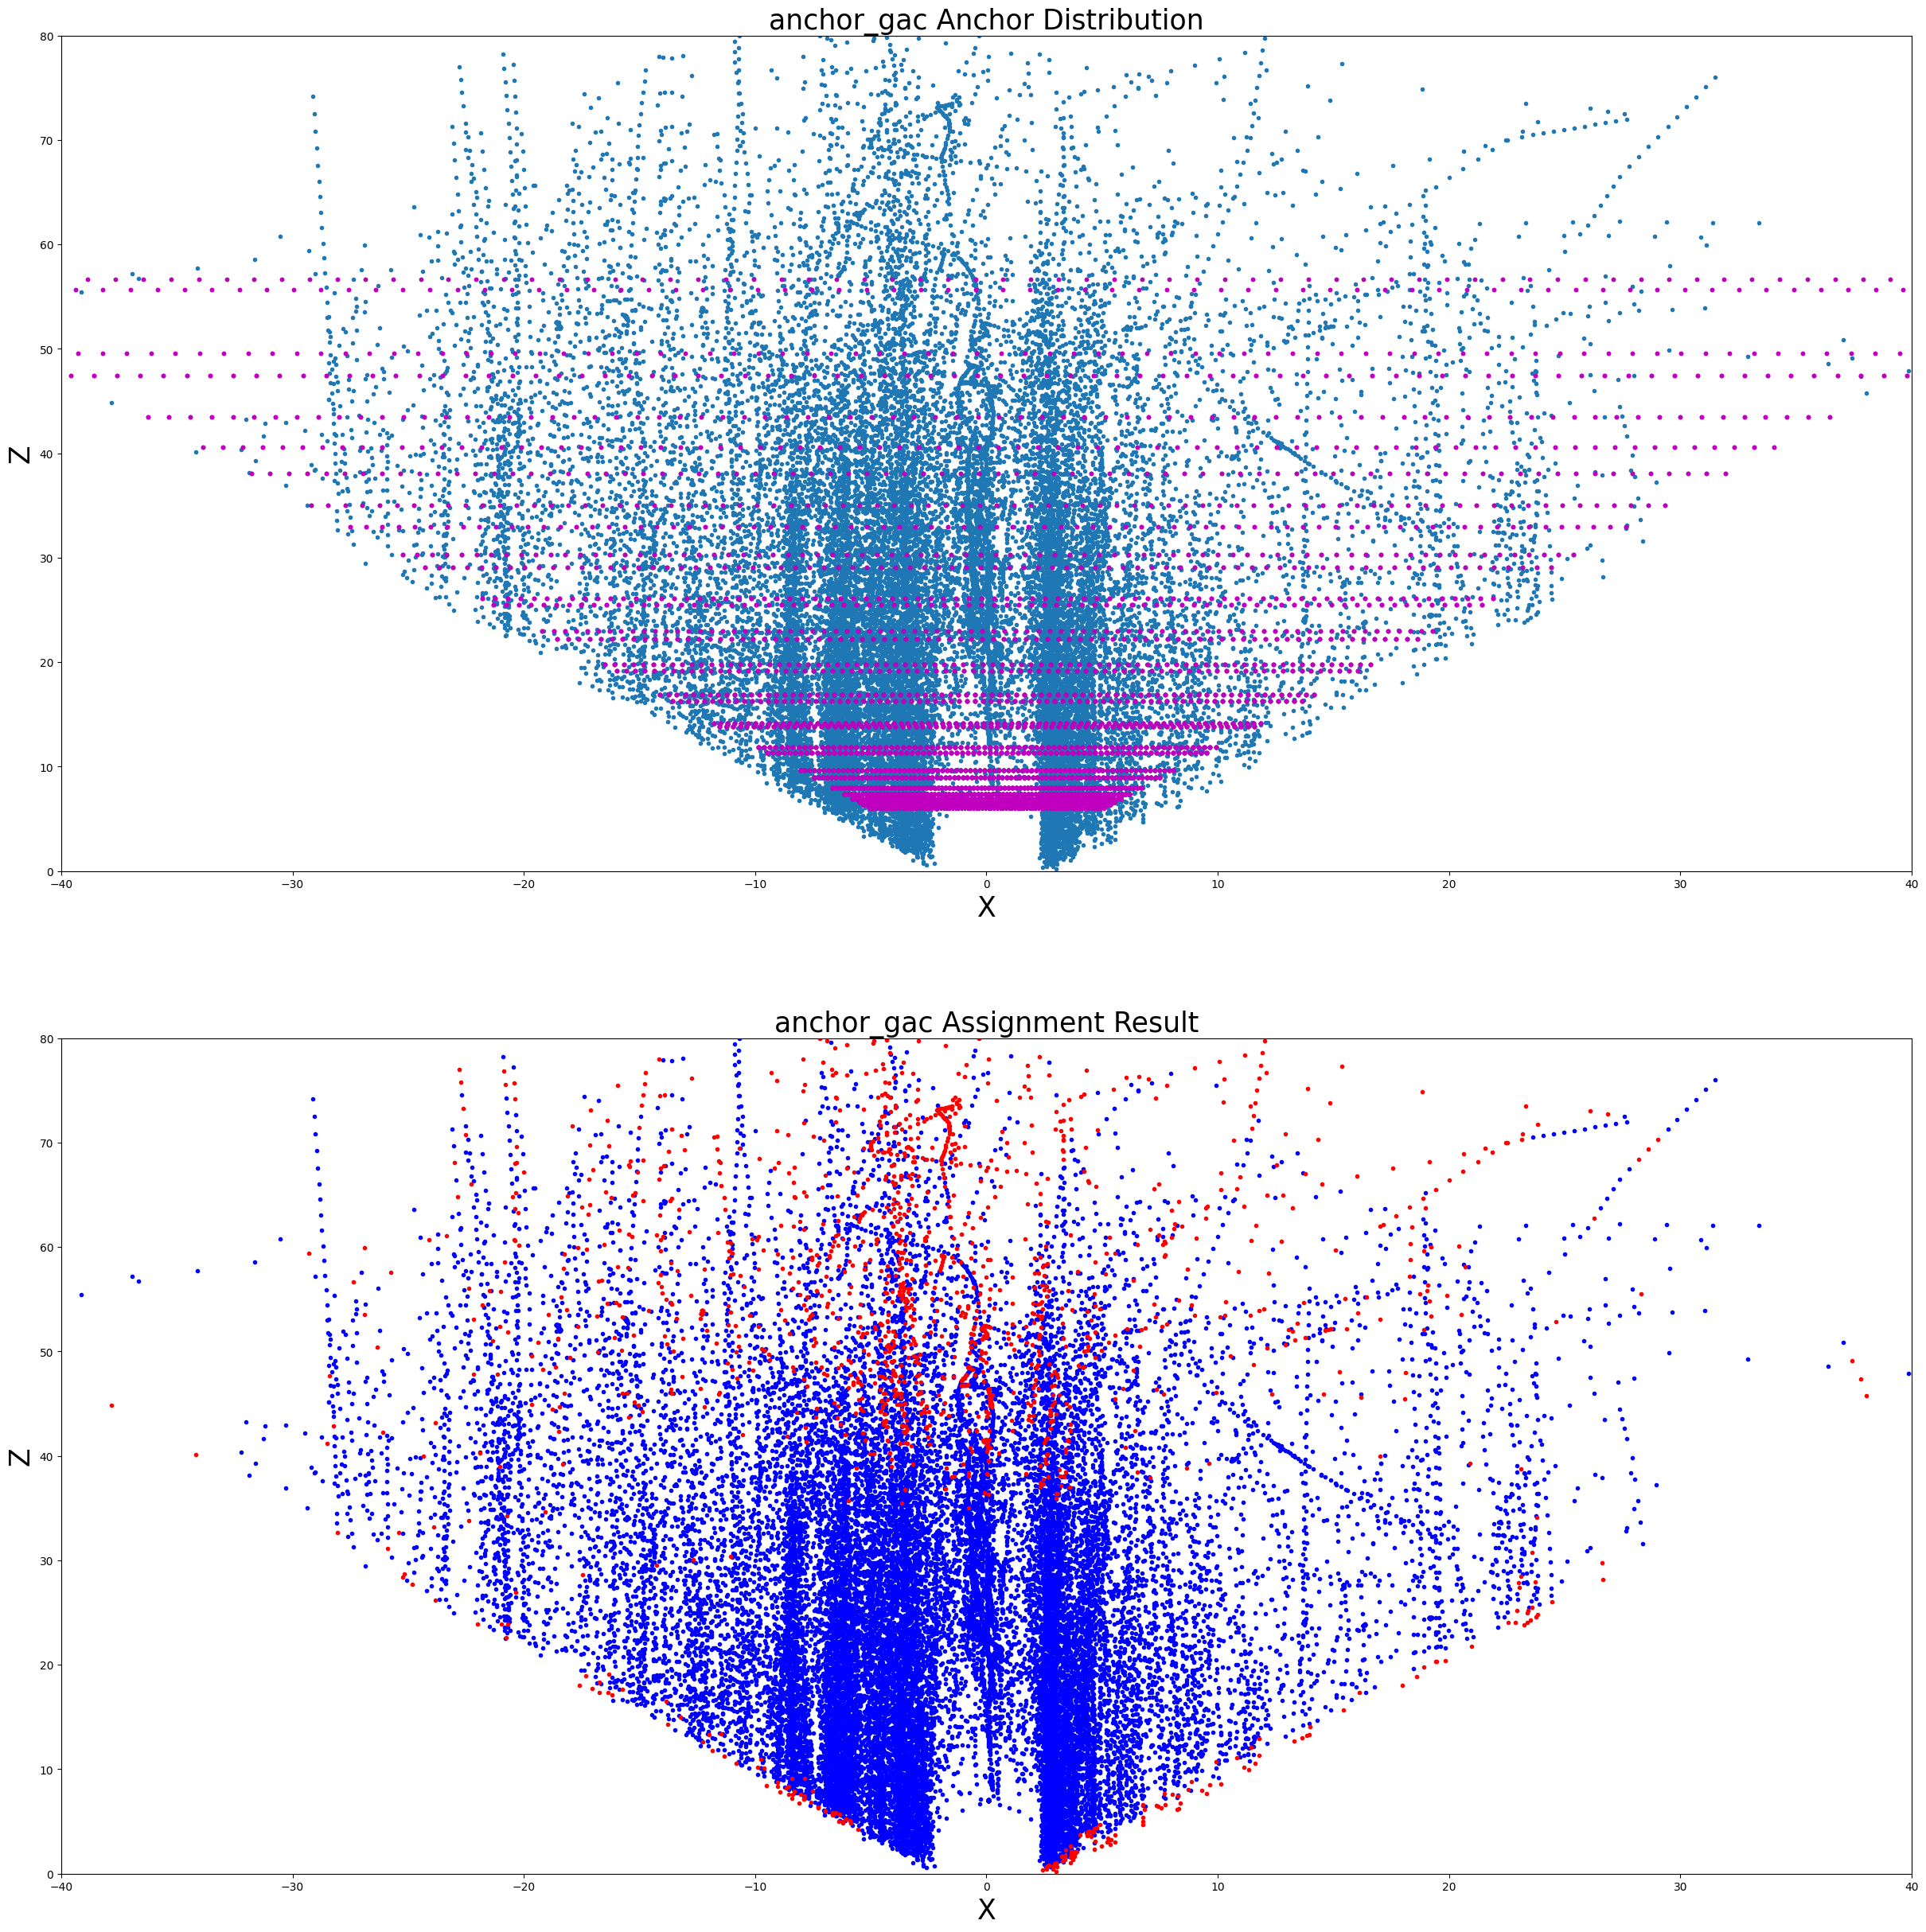

In [5]:
axs = init_xz_plt([f"{ANCHOR_GENERATION_METHOD} Anchor Distribution", f"{ANCHOR_GENERATION_METHOD} Assignment Result"])

# Draw Ground true
axs[0].plot([l.x3d for l in labels_all], [l.z3d for l in labels_all], '.') # Draw ground true

# Draw anchors
axs[0].plot([a.x3d for a in anchors], [a.z3d for a in anchors], '.m',) # Draw filtered GAC anchor

covered_gt_list = []
missed_gt_list = []
for i, assign_list in enumerate(gt_assign_result):
    if len(assign_list) > 0: # Covered gt
        covered_gt_list.append(i)
    else:
        missed_gt_list.append(i)

# Draw Assignemnt result
axs[1].plot([labels_all[i].x3d for i in covered_gt_list], [labels_all[i].z3d for i in covered_gt_list], '.b',)
axs[1].plot([labels_all[i].x3d for i in missed_gt_list], [labels_all[i].z3d for i in missed_gt_list], '.r',)



# Anchor Assignment on Image Plain

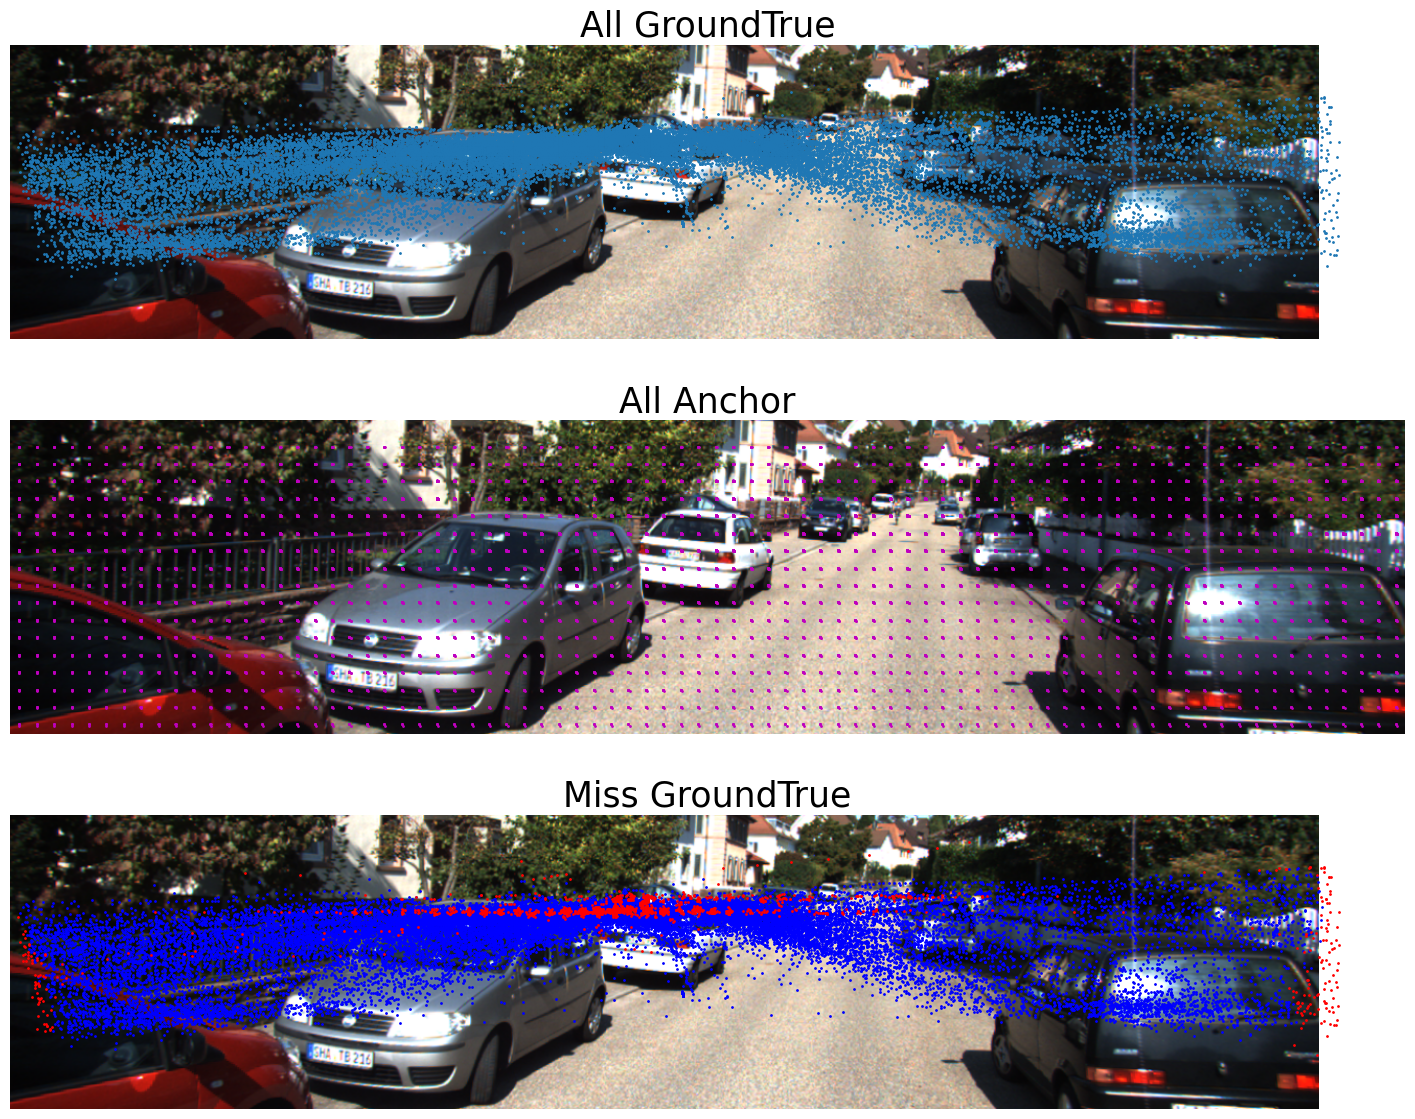

In [7]:
MARKER_SIZE = 2
axs = init_img_plt_without_bev([imgs_tf[1], imgs_tf[1], imgs_tf[1]], ["All GroundTrue", "All Anchor", "Miss GroundTrue"] )

# for l in labels_all:
#     if (l.xmin+l.xmax)/2 > 1280:
#         draw_2Dbox(axs[0], (l.xmin, l.ymin, l.xmax, l.ymax), color = (0,1,0))

# Draw Ground true
axs[0].plot([int((l.xmin+l.xmax)/2) for l in labels_all], 
            [int((l.ymin+l.ymax)/2) for l in labels_all], '.', markersize=MARKER_SIZE)

# Draw anchors
axs[1].plot([int((a.xmin+a.xmax)/2) for a in anchors], 
            [int((a.ymin+a.ymax)/2) for a in anchors], '.m', markersize=MARKER_SIZE)


covered_gts = [] # [[x,y], ...]
missed_gts  = [] # [[x,y], ...]
for i, assign_list in enumerate(gt_assign_result):
    if len(assign_list) > 0: # Covered gt
        covered_gts.append( [int((labels_all[i].xmin + labels_all[i].xmax)/2), 
                             int((labels_all[i].ymin + labels_all[i].ymax)/2)] )
    else:
        missed_gts.append( [int((labels_all[i].xmin + labels_all[i].xmax)/2), 
                            int((labels_all[i].ymin + labels_all[i].ymax)/2)] )

covered_gts = np.array(covered_gts)
missed_gts  = np.array(missed_gts)
# 
# Draw Assignemnt result
axs[2].plot(covered_gts[:,0], covered_gts[:,1], '.b',markersize=MARKER_SIZE)
axs[2].plot(missed_gts [:,0], missed_gts [:,1], '.r',markersize=MARKER_SIZE)

